In [1]:
import glob
import os
import shutil

import numpy as np
import pylab as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
from pipeline.python.utils import convert_range
import scipy.stats as spstats


from pipeline.python.utils import natural_keys, label_figure
from pipeline.python import utils as putils

import traceback
from pipeline.python.retinotopy import utils as ret_utils
from pipeline.python.rois import utils as roi_utils
from pipeline.python.paradigm import utils as par_utils
from pipeline.python.classifications import evaluate_receptivefield_fits as evalrf
import sklearn.metrics as skmetrics
from pipeline.python.coregistration import align_fov as coreg

import json
import tifffile as tf
from scipy import ndimage


import cv2
from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.colors as mcolors
import cPickle as pkl
import h5py

/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/utils.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/get_traces.py:96: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 65

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/paradigm/tifs_to_data_arrays.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py

In [2]:
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.classifications import rf_utils as rfutils

from sklearn.linear_model import LinearRegression, Ridge, Lasso

import scipy.stats as spstats
import sklearn.metrics as skmetrics 

import seaborn as sns
from pipeline.python import utils as utils


In [3]:
import imutils
from scipy.ndimage.morphology import binary_dilation
from pipeline.python.classifications import gradient_estimation as grd
import math

In [4]:
%matplotlib inline

In [5]:
import skimage
from skimage.color import label2rgb
from skimage.measure import label, regionprops, find_contours
import skimage.measure as skmeasure

import time

from skimage.measure import block_reduce


## Some aggregate plotting stuff

In [6]:
visual_areas, area_colors = utils.set_threecolor_palette()
dpi = utils.set_plot_params(lw_axes=2)

# Select colormap

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy', 'azimuth_pos_nic_Edge_LEGEND_abs')
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy', 'elevation_pos_nic_Edge_LEGEND_abs')


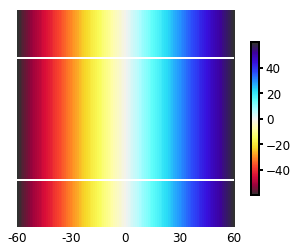

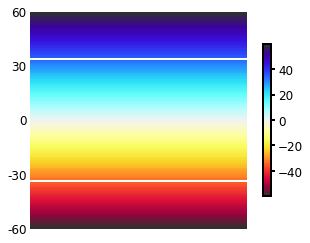

In [7]:
# # Load colormap
cmap_name = 'nic_Edge'
# zero_center = True
screen, cmap_phase = ret_utils.get_retino_legends(cmap_name=cmap_name, zero_center=True, 
                                                   return_cmap=True)

# Set output dirs

In [8]:
rootdir = '/n/coxfs01/2p-data'
aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

aggr_retino_dir = os.path.join(aggr_dir, 'retinotopy') #, 'figures', 'caiman-examples')
if not os.path.exists(aggr_retino_dir):
    os.makedirs(aggr_retino_dir)
aggr_retino_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy'

# Metadata

In [9]:
# Get all data sets
traceid='traces001'

sdata = aggr.get_aggregate_info(traceid=traceid) #, fov_type=fov_type, state=state)
retinodata = sdata[sdata['experiment']=='retino'].copy()
retinodata.groupby(['visual_area']).count()

,animalid,experiment,fov,session,fovnum,datakey
visual_area,,,,,,
Li,23,23,23,23,23,23
Lm,19,19,19,19,19,19
V1,15,15,15,15,15,15


In [10]:
# screen info
screen = putils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

# Example FOV ----------------------------------------------------------------------

In [11]:
curr_visual_area='V1'
retinodata[retinodata['visual_area']==curr_visual_area]

,animalid,experiment,fov,session,visual_area,fovnum,datakey
3,JC084,retino,FOV1_zoom2p0x,20190522,V1,1,20190522_JC084_fov1
41,JC085,retino,FOV1_zoom2p0x,20190622,V1,1,20190622_JC085_fov1
69,JC097,retino,FOV2_zoom2p0x,20190615,V1,2,20190615_JC097_fov2
74,JC097,retino,FOV1_zoom2p0x,20190617,V1,1,20190617_JC097_fov1
79,JC097,retino,FOV1_zoom2p0x,20190616,V1,1,20190616_JC097_fov1
84,JC097,retino,FOV1_zoom2p0x,20190613,V1,1,20190613_JC097_fov1
95,JC110,retino,FOV1_zoom2p0x,20191006,V1,1,20191006_JC110_fov1
97,JC110,retino,FOV2_zoom2p0x,20191004,V1,2,20191004_JC110_fov2
102,JC117,retino,FOV1_zoom2p0x,20191111,V1,1,20191111_JC117_fov1
123,JC076,retino,FOV1_zoom2p0x,20190420,V1,1,20190420_JC076_fov1


In [13]:
#animalid = 'JC113' #'JC091' #'JC097' #'JC085'
#session = '20191017' # '20190614' #'20190617' #'20190626'

animalid = 'JC097'
session = '20190615'
fovnum = 2

fov = 'FOV%i_zoom2p0x' % fovnum
traceid = 'traces001'

datakey='%s_%s_fov%i' % (session, animalid, fovnum)

# Get retino runs
found_retinoruns = [os.path.split(d)[-1] for d in 
                    glob.glob(os.path.join(rootdir, animalid, session, fov, 'retino*'))]
print("Found %i runs" % len(found_retinoruns))
retinorun = found_retinoruns[0]

Found 1 runs


In [14]:
# Load data metainfo
print("Current run: %s" % retinorun)
retinoid, RETID = ret_utils.load_retino_analysis_info(animalid, session, fov, retinorun, traceid, use_pixels=True)
data_id = '_'.join([animalid, session, fov, retinorun, retinoid])
print("DATA ID: %s" % data_id)

# Load MW info and SI info
mwinfo = ret_utils.load_mw_info(animalid, session, fov, retinorun)
scaninfo = ret_utils.get_protocol_info(animalid, session, fov, run=retinorun) 
trials_by_cond = scaninfo['trials']

# Set current animal's retino output dir
run_dir = RETID['DST'].split('/retino_analysis/')[0]
curr_dst_dir = os.path.join(run_dir, 'retino_analysis', 'segmentation')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
    print("Saving output to:\n %s" % curr_dst_dir)

Current run: retino_run1
FOV: FOV2_zoom2p0x, run: retino_run1
Fixed retino id to most recent: analysis001
DATA ID: JC097_20190615_FOV2_zoom2p0x_retino_run1_analysis001
Saving output to:
 /n/coxfs01/2p-data/JC097/20190615/FOV2_zoom2p0x/retino_run1/retino_analysis/segmentation


In [15]:
magratio, phase, trials_by_cond = ret_utils.fft_results_by_trial(RETID)

d2 = scaninfo['pixels_per_line']
d1 = scaninfo['lines_per_frame']
print("Original dims: [%i, %i]" % (d1, d2))

# Get ROIID and projection image
ds_factor = int(RETID['PARAMS']['downsample_factor'])
print('Data were downsampled by %i.' % ds_factor)

# Get pixel size
pixel_size = putils.get_pixel_size()
pixel_size = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)


Trials by cond:
{u'top': [14, 16, 1, 9], u'right': [13, 3, 2, 4], u'left': [11, 15, 5, 6], u'bottom': [10, 12, 7, 8]}
Original dims: [512, 512]
Data were downsampled by 2.


('got phase:', 5.9383780543598164e-05, 6.28314374705427)
('got absolute:', -2.9669279638661497, 2.7184630364056854)
('Delay:', 0.19424195222463347, 5.974772364991656)


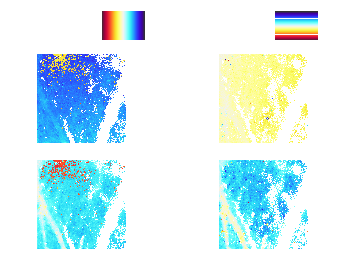

In [16]:
pix_mag_thr=0.003

abs_vmin, abs_vmax = (-np.pi, np.pi)
absolute_az, absolute_el, delay_az, delay_el = ret_utils.absolute_maps_from_conds(magratio, phase, trials_by_cond,
                                                                                 mag_thr=pix_mag_thr, dims=(d1, d2),
                                                                                 plot_conditions=False, ds_factor=ds_factor)

shift_az_delay = ret_utils.convert_values(delay_az, newmin=-np.pi, newmax=np.pi, 
                                          oldmin=0, oldmax=2*np.pi)
shift_el_delay = ret_utils.convert_values(delay_el, newmin=-np.pi, newmax=np.pi, 
                                          oldmin=0, oldmax=2*np.pi)

fig = ret_utils.plot_phase_and_delay_maps(absolute_az, absolute_el, 
                                          shift_az_delay, shift_el_delay,
                                         cmap=cmap_phase, vmin=abs_vmin, vmax=abs_vmax)


#### Shift maps to match

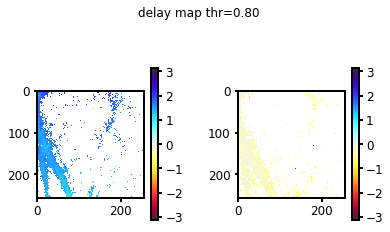

In [18]:
delay_map_thr=0.8

#shift_az_delay = ret_utils.convert_values(delay_az, newmin=-np.pi, newmax=np.pi, oldmin=0, oldmax=2*np.pi)
#shift_el_delay = ret_utils.convert_values(delay_el, newmin=-np.pi, newmax=np.pi, oldmin=0, oldmax=2*np.pi)

filt_az = np.where(abs(shift_az_delay)<delay_map_thr, absolute_az, np.nan)
filt_el = np.where(abs(shift_el_delay)<delay_map_thr, absolute_el, np.nan)

fig, axn = pl.subplots(1,2)
im0 = axn[0].imshow(filt_az, cmap=cmap_phase, vmin=-np.pi, vmax=np.pi)
pl.colorbar(im0, ax=axn[0], shrink=0.7, orientation='vertical')
im1 = axn[1].imshow(filt_el, cmap=cmap_phase, vmin=-np.pi, vmax=np.pi)
pl.colorbar(im1, ax=axn[1], shrink=0.7, orientation='vertical')

pl.suptitle("delay map thr=%.2f" % delay_map_thr)
pl.subplots_adjust(wspace=0.5)

## Get surface img

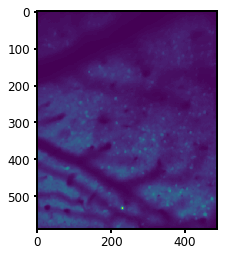

In [19]:
surface_img = ret_utils.load_2p_surface(animalid, session, fov, ch_num=1, retinorun=retinorun)
pixel_size = putils.get_pixel_size()
surface_2p = coreg.transform_2p_fov(surface_img, pixel_size, normalize=False)
surface_2p = putils.adjust_image_contrast(surface_2p, clip_limit=2.0, tile_size=5)

if surface_img.shape[0] != absolute_az.shape[0]:
    reduce_factor = surface_img.shape[0] / absolute_az.shape[0]
    surface_img = block_reduce(surface_img, (2,2), func=np.mean)


# transform to physical view
surface_transf = coreg.orient_2p_to_macro(surface_img, zoom_factor=1., save=False, normalize=True)
surface_r = coreg.scale_2p_fov(surface_transf, pixel_size=pixel_size)

surface = putils.adjust_image_contrast(surface_r, clip_limit=2.0, tile_size=5)

#print(surface_r.shape)
f, ax = pl.subplots(figsize=(4,4))
ax.imshow(surface)


#### Smooth

In [20]:
# Spatial smooth neuropil dilated masks 
nan_smooth=1
smooth_fwhm=7
use_phase_smooth=False

if use_phase_smooth:
    azim_smoothed = ret_utils.smooth_phase_nans(filt_az, smooth_fwhm,smooth_fwhm)
    elev_smoothed = ret_utils.smooth_phase_nans(filt_el, smooth_fwhm, smooth_fwhm)
else:
    azim_smoothed = ret_utils.smooth_neuropil(filt_az, smooth_fwhm=smooth_fwhm)
    elev_smoothed = ret_utils.smooth_neuropil(filt_el, smooth_fwhm=smooth_fwhm)

# azim_fillnan = fill_and_smooth_nans(azim_smoothed, kx=nan_smooth, ky=nan_smooth)
# elev_fillnan = fill_and_smooth_nans(elev_smoothed, kx=nan_smooth, ky=nan_smooth)
azim_fillnan = grd.fill_and_smooth_nans_missing(azim_smoothed, kx=nan_smooth, ky=nan_smooth)
elev_fillnan = grd.fill_and_smooth_nans_missing(elev_smoothed, kx=nan_smooth, ky=nan_smooth)

# Transform FOV to match widefield
azim_r = coreg.transform_2p_fov(azim_fillnan, pixel_size, normalize=False)
elev_r = coreg.transform_2p_fov(elev_fillnan, pixel_size, normalize=False)

az_fill = azim_r.copy()
el_fill = elev_r.copy()

vmin, vmax = (-np.pi, np.pi)

(u'/n/coxfs01/2p-data/JC097/20190615/FOV2_zoom2p0x/retino_run1/retino_analysis/segmentation', 'pixelmaps_smooth-7_magthr-0.003_delaymapthr-0.80')


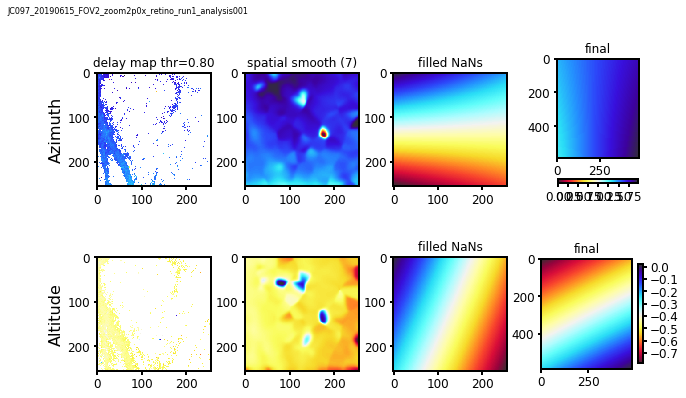

In [21]:
fig, axn = pl.subplots(2,4, figsize=(10,6))

ax = axn[0,0]
ax.imshow(filt_az, cmap=cmap_phase) #, vmin=vmin, vmax=vmax)
ax.set_ylabel('Azimuth')
ax.set_title('delay map thr=%.2f' % delay_map_thr)

ax = axn[0, 1]
ax.imshow(azim_smoothed, cmap=cmap_phase) #, vmin=vmin, vmax=vmax)
ax.set_title('spatial smooth (%i)' % smooth_fwhm)

ax = axn[0, 2]
im0 = ax.imshow(azim_fillnan, cmap=cmap_phase) #, vmin=vmin, vmax=vmax)
ax.set_title('filled NaNs')

ax = axn[0, 3]
im0 = ax.imshow(az_fill, cmap=cmap_phase) #, vmin=vmin, vmax=vmax)
ax.set_title('final')
pl.colorbar(im0, ax=ax, orientation='horizontal', shrink=0.7)

ax = axn[1, 0]
ax.imshow(filt_el, cmap=cmap_phase) #, vmin=vmin, vmax=vmax)
ax.set_ylabel('Altitude')

ax = axn[1, 1]
ax.imshow(elev_smoothed, cmap=cmap_phase) #, vmin=vmin, vmax=vmax)

ax = axn[1, 2]
im1= ax.imshow(elev_fillnan, cmap=cmap_phase) #, vmin=vmin, vmax=vmax)
ax.set_title('filled NaNs')

ax = axn[1, 3]
im1= ax.imshow(el_fill, cmap=cmap_phase) #, vmin=vmin, vmax=vmax)
ax.set_title('final')
pl.colorbar(im1, ax=ax, orientation='vertical', shrink=0.7)


pl.subplots_adjust(wspace=0.3, hspace=0.3)
putils.label_figure(fig, data_id)
figname = 'pixelmaps_smooth-%i_magthr-%.3f_delaymapthr-%.2f' % (smooth_fwhm, pix_mag_thr, delay_map_thr)
pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))
print(curr_dst_dir, figname)

# Do it all in one go

In [22]:
# animalid = 'JC091' #'JC091' #'JC097' #'JC085'
# session = '20191008' # '20190614' #'20190617' #'20190626'

# #animalid = 'JC090'
# #session = '20190605'
# fov = 'FOV1_zoom2p0x'
# retinorun = 'retino_run1'

In [23]:
# delay_map_thr =.5
# pix_mag_thr = 0.003
# smooth_fwhm = 7
# cmap_name = 'nic_Edge'

# az_fill, el_fill, params, RETID = grd.pixel_gradients(animalid, session, fov, 
#                                                       retinorun='retino_run1', 
#                 traceid=traceid, mag_thr=pix_mag_thr, delay_map_thr=delay_map_thr, 
#                 cmap=cmap_name, smooth_fwhm=smooth_fwhm) 


# Convert to screen units

In [24]:
plot_degrees = True

vmin=-np.pi
vmax=np.pi
img_az = convert_range(az_fill, oldmin=vmin, oldmax=vmax, newmin=screen_min, newmax=screen_max)
img_el = convert_range(el_fill, oldmin=vmin, oldmax=vmax, newmin=screen_min, newmax=screen_max)
vmin, vmax = (screen_min, screen_max)
    
print(vmin, vmax)

# Calculate gradients
# if plot_degrees:
#     grad_az = calculate_gradients(img_az)
#     grad_el = calculate_gradients(img_el)
#     vmin, vmax = (screen_min, screen_max)
# else:
#     grad_az = calculate_gradients(az_fill)
#     grad_el = calculate_gradients(el_fill)
#     # vmin, vmax = (-np.pi, np.pi)

spacing = 200
scale = None #0.0001
width = 0.01 #0.01
headwidth=5

plot_str = 'degrees' if plot_degrees else ''


(-59.7782, 59.7782)


# Identify borders using the gradients


In [25]:
def segment_areas(img_az, img_el, sign_map_thr=0.5, min_region_area=500, surface=None):
    # Calculate gradients
    # ---------------------------------------------------------
    h_map = img_el.copy()
    v_map = img_az.copy()
    [h_gy, h_gx] = np.array(grd.gradient_phase(h_map))
    [v_gy, v_gx] = np.array(grd.gradient_phase(v_map))

    h_gdir = np.arctan2(h_gy, h_gx) # gradient direction
    v_gdir = np.arctan2(v_gy, v_gx)

    # Create sign map
    # ---------------------------------------------------------
    gdiff = v_gdir-h_gdir
    gdiff = (gdiff + math.pi) % (2*math.pi) - math.pi

    #O=-1*np.sin(gdiff)
    O=np.sin(gdiff) # LEFT goes w/ BOTTOM.  RIGHT goes w/ TOP.
    S=np.sign(O) # Discretize into patches

    # Calculate STD, and threshold to separate areas (simple morph. step)
    # ---------------------------------------------------------
    O_sigma = np.nanstd(O)
    S_thr = np.zeros(np.shape(O))
    S_thr[O>(O_sigma*sign_map_thr)] = 1
    S_thr[O<(-1*O_sigma*sign_map_thr)] = -1
    
    return O, S_thr

def segment_and_label(S_thr):

    # Create segmented + labeled map
    # ---------------------------------------------------------
    filled_smap = grd.fill_nans(S_thr)
    labeled_image, n_labels = skimage.measure.label(
                                 filled_smap, background=0, return_num=True)

    image_label_overlay = label2rgb(labeled_image) #, image=segmented_img) 
    rprops_ = skmeasure.regionprops(labeled_image, filled_smap)
    region_props = [r for r in rprops_ if r.area > min_region_area]
    
    return region_props, labeled_image 

In [26]:
def plot_segmentation_steps(img_az, img_el, surface=None, O=None, S_thr=None, sign_map_thr=None, 
                           cmap='viridis', labeled_image=None, region_props=None):

    fig, axf = pl.subplots(2, 3, figsize=(8,8))
    axn = axf.flat

    ax=axn[0]; #ax.set_title(proc_info_str, loc='left', fontsize=12)
    im0 = ax.imshow(surface, cmap='gray'); ax.axis('off');

    ax=axn[1]
    im0 = ax.imshow(img_az, cmap=cmap); ax.axis('off');
    putils.colorbar(im0, label='az')

    ax=axn[2]
    im0 = ax.imshow(img_el, cmap=cmap); ax.axis('off');
    putils.colorbar(im0, label='el')

    ax=axn[3]; ax.set_title('Sign Map, O');
    im0 = ax.imshow(O, cmap='jet'); ax.axis('off');

    ax=axn[4]; ax.set_title('Visual Field Patches\n(std_thr=%.2f)' % sign_map_thr)
    im = ax.imshow(S_thr, cmap='jet'); ax.axis('off');

    cbar_ax = fig.add_axes([0.35, 0.1, 0.3, 0.02])
    cbar_ticks = np.linspace(-1, 1, 5)
    fig.colorbar(im, cax=cbar_ax, orientation='horizontal', ticks=cbar_ticks)
    cbar_ax.tick_params(size=0)

    ax = axn[5]
    ax.imshow(labeled_image)
    for ri, region in enumerate(region_props): 
        ax.text(region.centroid[1], region.centroid[0], 
                '%i' % region.label, fontsize=24, color='k')
    for index in np.arange(0, len(region_props)):
        label = region_props[index].label
        contour = find_contours(labeled_image == label, 0.5)[0]
        ax.plot(contour[:, 1], contour[:, 0], 'w')
    ax.set_title('Labeled (%i patches)' % len(region_labels))
    ax.axis('off')

    return fig


In [27]:
def overlay_contours(props, labeled_image, ax=None, lc='w', lw=2):
    if ax is None:
        fig, ax = pl.subplots()
        
    for index in np.arange(0, len(props)): # range(1, labeled_image.max()):
        label = props[index].label
        contour = find_contours(labeled_image == label, 0.5)[0]
        ax.plot(contour[:, 1], contour[:, 0], lc, lw=lw)
    return ax

In [28]:
def load_segmentation_results(animalid, session, fov, retinorun='retino_run1', rootdir='/n/coxfs01/2p-data'):
    results_fpath = os.path.join(rootdir, animalid, session, fov, retinorun, 
                              'retino_analysis', 'segmentation', 'results.pkl')
    
    assert os.path.exists(results_fpath), "Segmentation not found: %s" % results_fpath
    with open(results_fpath, 'r') as f:
        seg_areas = pkl.load(f)
        
    return seg_areas

# Segement areas

In [29]:
# Segmenting params
sign_map_thr = 0.5
min_region_area = 500
O, S_thr = segment_areas(img_az, img_el, sign_map_thr=sign_map_thr, 
                         min_region_area=min_region_area, surface=surface)
region_props, labeled_image  = segment_and_label(S_thr)

region_labels = [region.label for region in region_props]
print('Found %i regions' % len(region_labels))

labeled_image_2p = cv2.resize(labeled_image.astype(np.uint8), surface_2p.shape)

results = {'labeled_image_ds': labeled_image, 
           'labeled_image': labeled_image_2p,
           'region_props': region_props}


Found 1 regions


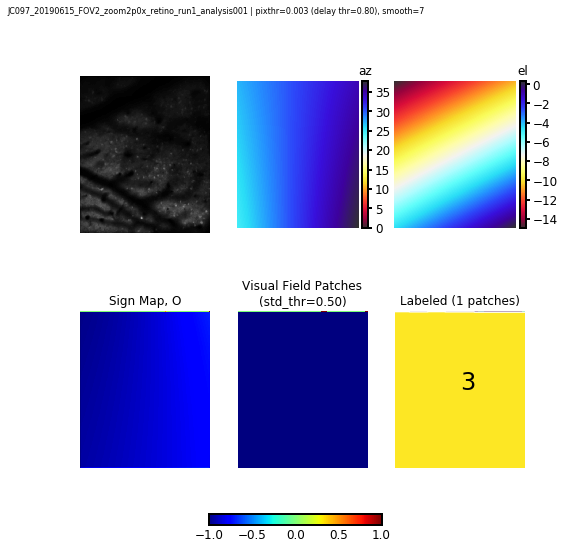

In [30]:
# Plot segmentation results
proc_info_str = 'pixthr=%.3f (delay thr=%.2f), smooth=%i' % (pix_mag_thr, delay_map_thr, smooth_fwhm)
fig = plot_segmentation_steps(img_az, img_el, surface=surface, O=O, S_thr=S_thr, sign_map_thr=sign_map_thr, 
                           cmap=cmap_phase, labeled_image=labeled_image, region_props=region_props)

label_figure(fig, '%s | %s' % (data_id, proc_info_str))
pl.subplots_adjust(hspace=0.5, bottom=0.2)
    
pl.savefig(os.path.join(curr_dst_dir, 'segemented_areas.png'))

# Select areas and label

In [31]:
region_dict={3: 'V1'}

seg_areas = {}
label_keys=[]
for ri, region in enumerate(region_props):
    region_id = region.label
    if region.label in region_dict.keys():
        region_name = region_dict[region.label]
        label_keys.append((region_name, region_id))
    else:
        region_name = region.label

    # save mask
    region_mask = np.copy(labeled_image.astype('float'))
    region_mask[labeled_image != region_id] = 0
    region_mask[labeled_image == region_id] = 1

    seg_areas[region_name] = {'id': region_id, 'mask': region_mask}
    

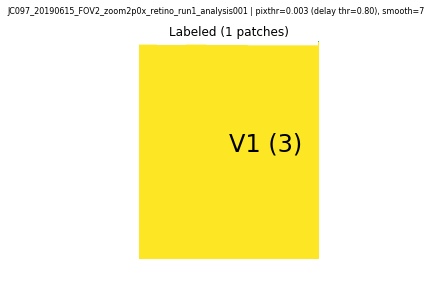

In [32]:
# double check labeling/naming of segmented areas
area_ids = [k[1] for k in label_keys]
fig, ax = pl.subplots()
ax.imshow(labeled_image)    
for region in region_props:
    if region.label in area_ids:
        region_name = str([k[0] for k in label_keys if k[1]==region.label][0])
        ax.text(region.centroid[1], region.centroid[0], 
                        '%s (%i)' % (region_name, region.label), fontsize=24, color='k')
    # plot
    contour = find_contours(labeled_image == region.label, 0.5)[0]
    ax.plot(contour[:, 1], contour[:, 0], 'w', lw=5)
ax.set_title('Labeled (%i patches)' % len(area_ids))
ax.axis('off')
putils.label_figure(fig, '%s | %s' % (data_id, proc_info_str))
pl.savefig(os.path.join(curr_dst_dir, 'labeled_areas.png'))

## Save results

In [33]:
segparams_fpath = os.path.join(curr_dst_dir, 'params.json')
segresults_fpath = os.path.join(curr_dst_dir, 'results.pkl')

seg_params = {'pixel_mag_thr': pix_mag_thr,
              'downsample_factor': ds_factor,
              'delay_map_thr': delay_map_thr,
              'smooth_fwhm': smooth_fwhm,
              'sign_map_thr': sign_map_thr,
              'min_region_area': min_region_area}

results.update({'areas': seg_areas})
results.update({'label_keys': label_keys})

with open(segparams_fpath, 'w') as f:
    json.dump(seg_params, f, indent=4, sort_keys=True)
    
with open(segresults_fpath, 'wb') as f:
    pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)

#### Test w/ morphological steps


In [34]:
# nozeros = S.copy()

# k1 = 3
# niter = 3
# kernel =  np.ones((k1, k1))
# closing_s1 = cv2.morphologyEx(S, cv2.MORPH_CLOSE, kernel, iterations=niter)

# k2 = 3
# niter=3
# kernel = np.ones((k2, k2))
# opening_1 = cv2.morphologyEx(closing_s1, cv2.MORPH_OPEN, kernel, iterations=niter)

# k3 = 3
# niter = 3
# kernel = np.ones((k3, k3))
# #dilation = cv2.dilate(opening_1, kernel, iterations=niter)
# dilation = cv2.morphologyEx(opening_1, cv2.MORPH_CLOSE, kernel, iterations=niter)

# #nozeros[S==0] = np.nan
# test_sm = grd.fill_nans(dilation)
# f, ax = pl.subplots() #pl.figure()
# im=ax.imshow(test_sm, cmap='jet')
# putils.colorbar(im)

# Do stuff with segementations

In [35]:
pixel_size

(2.3, 1.9)

## Assign cells to visual area(s)

In [36]:
import re
import matplotlib as mpl
from pipeline.python.coregistration import align_fov as coreg #import Animal, FOV, warp_im, transform_2p_fov

In [37]:
def get_transformed_rois(animalid, session, fov, retinorun='retino_run1', 
                        roi_id=None, traceid='traces001'):
    if roi_id is None:
        roi_id = roi_utils.get_roiid_from_traceid(animalid, session, fov, traceid=traceid)
    roi_masks, zprog_img = roi_utils.load_roi_masks(animalid, session, fov, rois=roi_id)
    print("Loaded rois: %s" % roi_id)
    d1, d2, nrois = roi_masks.shape

    pixel_size = putils.get_pixel_size()    
    # pixel_size = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)
    roi_masks_tr = np.dstack([coreg.transform_2p_fov(roi_masks[:, :, i].astype(float), pixel_size) \
                   for i in np.arange(0, nrois)]) # transform/orient
    roi_masks = roi_masks_tr.astype(bool).astype(int)
    
    return roi_masks


In [38]:
def label_roi_masks(seg_results, roi_masks):
    d1, d2, nrois = roi_masks.shape
    print("Roi masks:", d1, d2, nrois)
    roi_list = [roi_masks[:, :, r] for r in np.arange(0, nrois)] # list makes calc faster
    
    #print(seg_mask.shape)
    
    label_keys = seg_results['label_keys']
    roi_assignments={}
    for area_name, seg in seg_results['areas'].items():
        seg_mask = cv2.resize(seg['mask'], (d2, d1))
        id_mask = seg['id'] * seg_mask
        # area_ix = int([i[1] for i in label_keys if i[0]==area_name]) #area_names.index(area_name)+1
        incl_rois = np.array([i for i, rmask in enumerate(roi_list) if (id_mask*rmask).max()==seg['id']])
        roi_assignments[area_name]=list(incl_rois)

        # assign label to masks
        roi_masks[:,:,incl_rois] *= seg['id']
    
    return roi_assignments, roi_masks


In [39]:
def plot_segmented_rois(seg_results, roi_assignments, roi_masks, cmap='viridis', surface=None, ax=None):

    labeled_image = seg_results['labeled_image']
    region_props = seg_results['region_props']
    label_keys = seg_results['label_keys']
    
    d1, d2, nrois = roi_masks.shape
    
    # Check that ROI masks are labeled by their segment ID
    all_ids = [i for i in np.unique(roi_masks) if i>0]
    unique_ids = [k[1] for k in label_keys]
    rois_are_labeled=True
    if any([i not in unique_ids for i in all_ids]):
        rois_are_labeled=False
    
    # Plot rois on visual areas
    roi_int_img = np.zeros((d1, d2))
    for ri in np.arange(0, nrois):
        curr_msk = roi_masks[:, :, ri].copy()
        if rois_are_labeled:
            roi_int_img[curr_msk>0] = curr_msk.max()
        else:
            roi_int_img[curr_msk>0] = (ri+1) #curr_msk.max()
            
    # plot
    if ax is None:
        fig, ax = pl.subplots(figsize=(3,4))
    plot_roi_area_mask_overlay(labeled_image, region_props, roi_int_img=roi_int_img, 
                               surface=surface, cmap=cmap, ax=ax)
    # ax.set_title('Rois overlaid with area contours')
    ax = overlay_contours(region_props, labeled_image, ax=ax, lw=2, lc='w')
    add_id_legend(label_keys, ax, cmap=cmap, bbox_to_anchor=(1.1, 1))

    return ax


In [40]:
def assign_rois_to_visual_area(animalid, session, fov, retinorun='retino_run1',roi_id=None, 
                                traceid='traces001', return_labeled_masks=False, verbose=False):

    # Load ROIs
    roi_masks = get_transformed_rois(animalid, session, fov, retinorun=retinorun, 
                                     traceid=traceid)
    d1, d2, nrois = roi_masks.shape

    # Load segmentation results
    seg_results = roi_utils.load_segmentation_results(animalid, session, fov, retinorun=retinorun)

    # Assign each ROI to visual areas
    roi_assignments, roi_masks_labeled = label_roi_masks(seg_results, roi_masks)
    
    # Save assignments
    assignments_fpath = os.path.join(curr_dst_dir, 'roi_assignments.json')
    with open(assignments_fpath, 'w') as f:
        json.dump(roi_assignments, f, indent=4)

    if verbose:
        for v, r in roi_assignments.items():
            print("%s: %i cells" % (v, len(r)))

    if return_labeled_masks:
        return roi_assignments, roi_masks_labeled
    else:
        return roi_assignments


In [41]:
def plot_roi_area_mask_overlay(labeled_image, region_props, roi_masks=None, roi_int_img=None, 
                               surface=None, ax=None, cmap='hsv'):
    '''
    One of roi_masks or roi_ints must NOT be None.
    
    roi_masks: 3d array of masks (d1, d2, nrois)
    roi_ints: same shape as roi_masks, but 1's are assigne integer values for plotting (None, will be sequential)

    labeled_image: image with assigned segmentations
    region_props: oputput of skimage.measure.region_props() on gradient/signed maps
    '''
    if ax is None:
        f, ax = pl.subplots() 
    
    if roi_masks is not None:
        d1, d2, nrois = roi_masks.shape
    else:
        d1, d2 = roi_int_img.shape
        
    if surface is None:
        surface = np.zeros((d1, d2))
        
    if roi_int_img is None:
        roi_int_img = roi_utils.assign_int_to_masks(roi_masks)
    
    vmin=roi_int_img.min()
    vmax=roi_int_img.max()
    
    roi_utils.plot_roi_overlay(roi_int_img, surface, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax)
    ax = overlay_contours(region_props, labeled_image, ax=ax, lw=2, lc='w')

    return ax


def add_id_legend(label_keys, ax, cmap='viridis', bbox_to_anchor=(1,1)):
    label_ids = [v[1] for v in label_keys]
    vmin, vmax = 0, max(label_ids)
    
    cmap = mpl.cm.get_cmap(cmap)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    id_colors = [cmap(norm(i)) for (n, i) in label_keys]
    id_names = [n for (n, i) in label_keys]
    lhandles = putils.custom_legend_markers(colors=id_colors, labels=id_names)
    ax.legend(handles=lhandles, bbox_to_anchor=bbox_to_anchor)


# Load data

In [42]:
#### Get roi masks 
traceid= 'traces001'
roi_id = None
if roi_id is None:
    roi_id = roi_utils.get_roiid_from_traceid(animalid, session, fov, traceid=traceid)
r_masks, zprog_img = roi_utils.load_roi_masks(animalid, session, fov, rois=roi_id)
print("Loaded rois: %s" % roi_id)
d1, d2, nrois = r_masks.shape

##### Reshape and transform to match 'natural view'
pixel_size = putils.get_pixel_size() #* ds_factor
roi_masks_tr = np.dstack([coreg.transform_2p_fov(r_masks[:, :, i].astype(float), pixel_size) \
               for i in np.arange(0, nrois)]) # transform/orient
roi_masks = roi_masks_tr.astype(bool).astype(int)
print(roi_masks.shape)

Loaded rois: rois002
(1177, 972, 338)


## Assign roi IDs to visual area

In [43]:
seg_results = load_segmentation_results(animalid, session, fov, retinorun=retinorun)
seg_areas = seg_results['areas']

Loaded rois: rois002
('Roi masks:', 1177, 972, 338)


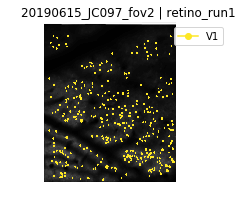

In [44]:
id_cmap='viridis'
plot_rois=True

return_labeled_masks=True
verbose=False

roi_assignments, roi_masks_labeled = assign_rois_to_visual_area(animalid, session, fov, 
                                                        retinorun=retinorun, traceid=traceid,
                                                        return_labeled_masks=return_labeled_masks, verbose=verbose)

if plot_rois:
    f, ax = pl.subplots(figsize=(3,4))
    plot_segmented_rois(seg_results, roi_assignments, roi_masks_labeled, cmap=id_cmap, surface=surface_2p, ax=ax)
    putils.label_figure(fig, data_id)
    ax.set_title('%s | %s' % (datakey, retinorun))
    pl.savefig(os.path.join(curr_dst_dir, 'assigned_rois.svg'))


In [1514]:
# class FOV():
#     def __init__(self, animalid, session, fov, rootdir='/n/coxfs01/2p-data'):
#         self.animalid = animalid
#         self.session = session
#         self.fov = fov
#         self.run_list = get_run_list(animalid, session, fov)
                 
#     def segment_visual_areas(self):

# class Struct():
#     pass

## Calculate gradient for segmented areas

In [45]:
seg_results = load_segmentation_results(animalid, session, fov, retinorun=retinorun)
seg_areas = seg_results['areas']
region_props = seg_results['region_props']

In [46]:
curr_visual_area = 'V1'

# Calculate gradients within mask
msk_ = seg_areas[curr_visual_area]['mask']

thr_img_az = img_az.copy()
thr_img_az[msk_==0] = np.nan
grad_az = grd.calculate_gradients(thr_img_az)

thr_img_el = img_el.copy()
thr_img_el[msk_==0] = np.nan
grad_el = grd.calculate_gradients(thr_img_el)

# Get average unit vector
avg_dir_el = np.rad2deg(grad_el['mean_direction'])
print('[EL] avg dir: %.2f deg' % avg_dir_el)
vhat_el = grad_el['vhat']

avg_dir_az = np.rad2deg(grad_az['mean_direction'])
print('[AZ] avg dir: %.2f deg' % avg_dir_az)
vhat_az = grad_az['vhat']

[EL] avg dir: 62.72 deg
[AZ] avg dir: 2.20 deg


(u'/n/coxfs01/2p-data/JC097/20190615/FOV2_zoom2p0x/retino_run1/retino_analysis/segmentation', 'gradients_V1')


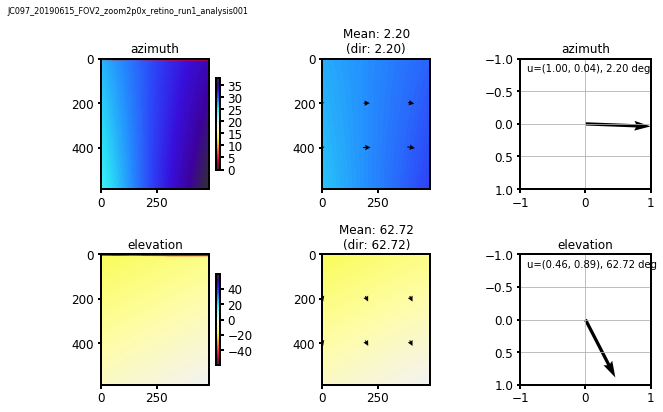

In [47]:
contour_color='r'

fig, axn = pl.subplots(2,3, figsize=(10,6))

# Maps ------------
ax=axn[0, 0]
im = ax.imshow(img_az,cmap=cmap_phase) #, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax, shrink=0.7)
ax.set_title('azimuth')
ax = overlay_contours(region_props, labeled_image, ax=ax, lw=2, lc=contour_color)

ax=axn[1, 0]
im = ax.imshow(img_el,  cmap=cmap_phase, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax, shrink=0.7)
ax.set_title('elevation')
ax = overlay_contours(region_props, labeled_image, ax=ax, lw=2, lc=contour_color)

# Gradients ------------   
ax=axn[0,1]
ax.imshow(thr_img_az, cmap=cmap_phase, vmin=vmin, vmax=vmax)
grd.plot_gradients(grad_az, ax=ax, draw_interval=spacing, scale=scale, width=width,
              headwidth=headwidth)
ax=axn[1, 1]
ax.imshow(thr_img_el, cmap=cmap_phase, vmin=vmin, vmax=vmax)
grd.plot_gradients(grad_el, ax=ax, draw_interval=spacing, scale=scale, width=width,
              headwidth=headwidth)

# Unit vectors ------------
ax= axn[0,2]
ax.grid(True)
ax.set_title('azimuth')
vh = grad_az['vhat'].copy()
az_dir = np.rad2deg(np.arctan2(vh[1], vh[0])) #+ 360.) % 360
vhat_az = (np.cos(np.deg2rad(az_dir)), np.sin(np.deg2rad(az_dir)))
ax.text(-.9, -.8, "u=(%.2f, %.2f), %.2f deg" % (vhat_az[0], vhat_az[1], az_dir))
ax.quiver(0,0, vhat_az[0], vhat_az[1],  scale=1, scale_units='xy', 
          units='xy', angles='xy', width=.05, pivot='tail')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal')
ax.invert_yaxis()

ax = axn[1,2]
ax.grid(True)
ax.set_title('elevation')
el_dir = np.rad2deg(np.arctan2(vhat_el[1], vhat_el[0]))
ax.text(-0.9, -0.8, "u=(%.2f, %.2f), %.2f deg" % (vhat_el[0], vhat_el[1], el_dir))
ax.quiver(0,0, vhat_el[0], vhat_el[1],  scale=1, scale_units='xy', 
          units='xy', angles='xy', width=.05, pivot='tail')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal')
ax.invert_yaxis()

# Figure formatting ------------
pl.subplots_adjust(wspace=0.5, hspace=0.5)
label_figure(fig, data_id)

figname = 'gradients_%s' % curr_visual_area
pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))
print(curr_dst_dir, figname)

In [1515]:
# region_dict={}
# for l in region_labels:
#     n = input("Input region name ID=%i: " % l)
#     if len(n)==0:
#         print("Skipping label %i" % l)
#         continue
#     region_dict.update({l: n})

#region_dict = {1:'Li', 2: '2', 3: '3'}